In [ ]:
import datetime
from collections import defaultdict
import warnings
import pickle
from scipy.optimize import minimize
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.callbacks import ModelCheckpoint
import stock_indicators as sa
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import yfinance as yf
from stock_indicators import Quote
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from stock_indicators.indicators.common.enums import PeriodSize
from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import GARCH

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.6f}'.format)

In [ ]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)

In [ ]:
funds_w_names = defaultdict(pd.DataFrame)

In [ ]:
etf_names = ['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS','IE00B0M62X26','IE00B14X4Q57','IE00B1XNHC34','IE00B3FH7618','IE00B3ZW0K18','IE00B52MJY50','IE00B5M4WH52','IE00B66F4759','EMBE.L', 'DTLE.L','IE00BDFK1573','IBC5.DE','IE00BFNM3G45','IE00BHZPJ015','IE00BHZPJ452','IE00BHZPJ783',
'IE00BLDGH553','IE00BMG6Z448','IE00BYYHSM20','IE00BYZTVT56','IE00BZ173V67','IE00BZ1NCS44','ISVIF', "IESE.AS", "UEEF.DE"]

In [ ]:
for fund in etf_names:
    print(fund)
    a = (pd.DataFrame(yf.Ticker(fund).history(start="2023-01-03", end="2024-01-01")))
    a.index = pd.to_datetime(a.index)
    
    a.index = a.index.normalize()

    full_date_range = pd.date_range(start=a.index.min(), end=a.index.max(), freq="D")
    a = a.reindex(full_date_range)
    a.index = a.index+datetime.timedelta(hours=1)
    a["Return"] = a["Close"].pct_change()
    a["Rolling Volatility"] = a["Return"].rolling(7).std()

    a.fillna(method="bfill", inplace=True)
    if fund != 'ISVIF':
        a.drop(["Dividends", "Stock Splits", "Capital Gains"], inplace=True, axis=1)
    else:
        a.drop(["Dividends", "Stock Splits"], inplace=True, axis=1)
    a.index = pd.to_datetime(a.index, utc=True)

    a = a.sort_index()

    a["time_idx"] = (a.index - a.index.min()).days
    a["group_id"] = fund
    funds_w_names[fund] = a

In [ ]:
# pickle.dump(funds_w_names, open('funds_w_names.pkl', 'wb'))

In [ ]:
# import pickle
# pickle.dump(funds_w_names, open('funds_w_names_2.pkl', 'wb'))

In [ ]:
funds_w_names = pd.read_pickle('funds_w_names_2.pkl')

In [ ]:
# def portfolio_factory(etfs: list):
#     #giga_fund = pd.DataFrame()
#     for c, ff in enumerate(etfs):
#         #f = ff.copy()
#
#         ff.index = pd.to_datetime(ff.index, utc=True)
#         if ff.index.hour[0]==0:
#             ff.index = ff.index+datetime.timedelta(hours=-1)
#         ff.index = ff.index.normalize()
#
#         ff = ff.sort_index()
#
#         ff["time_idx"] = (ff.index - ff.index.min()).days
#         ff["group_id"] = c
#         #f = f.reset_index()
#
#         #giga_fund = pd.concat([giga_fund, f], ignore_index=True)
#     #return giga_fund

In [ ]:
def technical_indicators_factory(etfs: list, names: list):
    indicators_per_fund = defaultdict(pd.DataFrame)
    figs = []

    for id, f in enumerate(etfs):
        quotes_for_f = [
            Quote(
                date=row.Index,
                open=row.Open,
                high=row.High,
                low=row.Low,
                close=row.Close,
                volume=row.Volume
            )
            for row in f.itertuples()]


        macd_for_f = sa.indicators.get_macd(quotes=quotes_for_f)
        valid_macd_for_f = [
            (result.date, result.macd, result.signal, result.histogram)
            for result in macd_for_f
            if result.macd is not None and result.signal is not None and result.histogram is not None
        ]
        macd_dates, macd_values, macd_signal, macd_histogram = zip(*valid_macd_for_f)


        rsi_for_f = sa.indicators.get_rsi(quotes=quotes_for_f)
        valid_rsi_for_f = [
            (result.date, result.rsi)
            for result in rsi_for_f
            if result.date is not None and result.rsi is not None
        ]
        rsi_dates, rsi_values = zip(*valid_rsi_for_f)


        bb_for_f = sa.indicators.get_bollinger_bands(quotes=quotes_for_f)
        valid_bb_for_f = [
            (result.date, result.lower_band, result.upper_band)
            for result in bb_for_f
            if result.date is not None and result.lower_band is not None
        ]
        bb_dates, bb_lower, bb_upper = zip(*valid_bb_for_f)


        vwap_for_f = sa.indicators.get_vwap(quotes=quotes_for_f)
        valid_vwap_for_f = [
            (result.date, result.vwap)
            for result in vwap_for_f
            if result.date is not None and result.vwap is not None
        ]
        vwap_dates, vwap_values = zip(*valid_vwap_for_f)



        pp_for_f = sa.indicators.get_pivot_points(quotes=quotes_for_f, window_size=PeriodSize.DAY)
        valid_pp_for_f = [
            (result.date, result.pp, result.r1, result.r2, result.r3, result.r4, result.s1, result.s2, result.s3, result.s4)
            for result in pp_for_f
            if result.date is not None and result.pp is not None
        ]
        pp_dates, pp, r1, r2, r3, r4, s1, s2, s3, s4 = zip(*valid_pp_for_f)




        fig, axes = plt.subplots(5, 1, figsize=(12,6))


        axes[0].plot(macd_dates[-20:], macd_values[-20:], label='MACD_values', linewidth=2)
        axes[0].plot(macd_dates[-20:], macd_signal[-20:], label='MACD_signal', linewidth=2)
        axes[0].legend(loc='best')

        axes[1].plot(rsi_dates[-20:], rsi_values[-20:], label='RSI', linewidth=2)
        axes[1].legend(loc='best')

        axes[2].plot(bb_dates[-20:], bb_lower[-20:], label='BB_lower', linewidth=2)
        axes[2].plot(bb_dates[-20:], bb_upper[-20:], label='BB_upper', linewidth=2)
        axes[2].legend(loc='best')

        axes[3].plot(vwap_dates[-20:], vwap_values[-20:], label='vwap', linewidth=2)
        axes[3].legend(loc='best')

        axes[4].plot(pp_dates[-20:], pp[-20:], label='pivot points', linewidth=2)
        axes[4].plot(pp_dates[-20:], r1[-20:], label='r1', linewidth=2)
        axes[4].plot(pp_dates[-20:], r4[-20:], label='r4', linewidth=2)
        axes[4].plot(pp_dates[-20:], s1[-20:], label='s1', linewidth=2)
        axes[4].plot(pp_dates[-20:], s4[-20:], label='s4', linewidth=2)
        axes[4].legend(loc='best')


        figs.append(fig)

        f['Bullish'] = [1 if x.histogram and x.histogram > 0 else 0 for x in macd_for_f]
        f['Bearish'] = [1 if x.histogram and x.histogram < 0 else 0 for x in macd_for_f]
        f['isOverbought'] = [1 if x.rsi and x.rsi > 70 else 0 for x in rsi_for_f ]
        f['isOversold'] = [1 if x.rsi and x.rsi < 30 else 0 for x in rsi_for_f ]


        f.fillna(method="ffill", inplace=True)
        indicators_per_fund[names[id]]= f
    return indicators_per_fund, figs

In [ ]:
def fit(epochs: int, batch_size: int, df: pd.DataFrame, independent_variables: list, target="Close", training_cutoff_idx: pd.Timestamp=330, max_prediction_length=61, min_encoder_length=22):
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff_idx],     # Use the determined cutoff index
        time_idx="time_idx",                                 # Sequential time index
        target=target,                                       # Target variable
        group_ids=["group_id"],                              # Group identifier
        min_encoder_length=min_encoder_length,                               # Minimum input sequence length
        max_encoder_length=365,                              # Maximum input sequence length
        min_prediction_length=1,                             # Minimum forecast length
        max_prediction_length=max_prediction_length,                            # Maximum forecast length (31 for December)
        static_categoricals=["group_id"],
        static_reals=[],                                     # No static real variables
        time_varying_known_reals= independent_variables,     # Known inputs
        time_varying_unknown_reals=[target],                 # Target variable
        target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
        add_relative_time_idx=True,                          # Add relative time index
        add_target_scales=True,                              # Scale the target variable
        add_encoder_length=True,                             # Include encoder length feature
        allow_missing_timesteps=False,                       # Ensure no missing steps
    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=True,
        stop_randomization=True                             # Ensures no randomization in validation dataset
    )

    batch_size = batch_size

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


    # study = optimize_hyperparameters(
    #     train_dataloader,
    #     val_dataloader,
    #     model_path="optuna_test",
    #     n_trials=200,
    #     max_epochs=50,
    #     gradient_clip_val_range=(0.01, 1.0),
    #     hidden_size_range=(8, 128),
    #     hidden_continuous_size_range=(8, 128),
    #     attention_head_size_range=(1, 4),
    #     learning_rate_range=(0.001, 0.1),
    #     dropout_range=(0.1, 0.3),
    #     trainer_kwargs=dict(limit_train_batches=30),
    #     reduce_on_plateau_patience=4,
    #     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    # )
    #
    # with open("test_study.pkl", "wb") as fout:
    #     pickle.dump(study, fout)
    #
    # print(study.best_trial.params)

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=0.0025,                # Learning rate
        hidden_size=88,                  # Model hidden size
        attention_head_size=4,           # Number of attention heads
        dropout=0.27,                 # Dropout rate
        hidden_continuous_size=44,       # Hidden size for continuous variables
        output_size=7,                   # Output quantiles (e.g., 10th to 90th percentile)
        loss=QuantileLoss(),             # Loss function
        log_interval=10,                 # Log every 10 batches
        reduce_on_plateau_patience=4,    # Reduce learning rate on plateau
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints/",
        filename="tft-model-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        monitor="val_loss",
        mode="min",  # minimize validation loss
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=8, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    trainer = pl.Trainer(
        # logger=logger,
        max_epochs=epochs,
        accelerator='cuda',
        devices="auto",
        gradient_clip_val=0.018,
        callbacks=[early_stop_callback, lr_logger],#, checkpoint_callback],
    )

    trainer.fit(tft, train_dataloader, val_dataloader)
    return tft, val_dataloader

In [ ]:
def predictt(tft, data):
    # pred_data = TimeSeriesDataSet.from_dataset(
    #     dataset=training,
    #     data=data,
    #     predict=True,
    #     stop_randomization=True)
    # 
    # pred_dataloader = pred_data.to_dataloader(train=False, batch_size=64 * 10, num_workers=0)

    raw_predictions = tft.predict(data, mode="raw", return_x=True)
    predicted_median_np = raw_predictions.output.prediction[0, :, 1].detach().cpu().numpy()
    return predicted_median_np

In [ ]:
def huber_loss(actual_val, pred_val, delta=5.0):
    err = np.abs(actual_val - pred_val)
    return np.mean(np.where( err <= delta, 0.5 * err**2, delta * (err - 0.5 * delta)))

In [ ]:
def relative_squared_error(true, pred):
    true_mean = np.mean(true)
    squared_error_num = np.sum(np.square(true - pred))
    squared_error_den = np.sum(np.square(true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return rse_loss

def relative_absolute_error(true, pred):
    true_mean = np.mean(true)
    squared_error_num = np.sum(np.abs(true - pred))
    squared_error_den = np.sum(np.abs(true - true_mean))
    rae_loss = squared_error_num / squared_error_den
    return rae_loss

In [ ]:
def metrics_and_plt(df: pd.DataFrame, preds:list, date_range:pd.date_range, target="Close", date = "2023-12-01"):
    print(len(df))
    print(len(preds))
    actual_values = df[target][date:]
    rse = relative_squared_error(actual_values, preds)
    rae = relative_absolute_error(actual_values, preds)
    huber = huber_loss(actual_values, preds)
    plt.figure(figsize=(10, 6))
    plt.plot(date_range, actual_values, marker="x", label="Actual Close", color="orange")
    plt.plot(date_range, preds, marker="o", label="Predicted Median")
    plt.title("Predicted Values for December 01 to December 29, 2023")
    plt.xlabel("Date")
    plt.ylabel("Predicted Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    return rse, rae, huber, plt

BASELINE MODEL

In [ ]:
f1 = funds_w_names['EWSA.AS']["Close"][:-30]

In [ ]:
model = ARIMA(f1, order=(1, 1, 1))
model_fit = model.fit()
arima_forecast = model_fit.forecast(steps=30)
print("ARIMA Forecast for the next 30 periods:", arima_forecast)

In [ ]:
arima_mse = mean_squared_error(funds_w_names["EWSA.AS"]["Close"][-30:], arima_forecast)

In [ ]:
sf = StatsForecast(models=[GARCH()], freq='D')
f1=pd.DataFrame(f1)
f1['ds'] = pd.to_datetime(f1.index)
f1.rename(columns={'Close': 'y'}, inplace=True)
f1['unique_id']=1

In [ ]:
garch_forecast = sf.forecast(h=30, df=f1)

print(garch_forecast)

In [ ]:
garch_mse = mean_squared_error(funds_w_names["EWSA.AS"]["Rolling Volatility"][-30:], garch_forecast["GARCH(1,1)"])

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12,6))


axes[0].plot(f1['ds'][-30:], arima_forecast[-30:], label='arima_forecast', linewidth=2)
axes[0].plot(f1['ds'][-30:], funds_w_names["EWSA.AS"]["Close"][-30:], label='Close', linewidth=2)
axes[0].legend(loc='best')
axes[1].plot(f1['ds'][-30:], garch_forecast["GARCH(1,1)"], label='garch_forecast', linewidth=2)
axes[1].plot(f1['ds'][-30:], funds_w_names["EWSA.AS"]["Rolling Volatility"][-30:], label='Volatility', linewidth=2)
axes[1].legend(loc='best')
plt.legend()
plt.show()

1) ONE FUND, NO INDICATORS, PRICE

In [ ]:
#IE00B52MJY50
#IE = portfolio_factory(etfs=[funds_w_names['EWSA.AS']])

In [ ]:
funds_w_names['EWSA.AS'][:"2023-10-29"]

In [ ]:
IE_tft, val = fit(epochs=100, batch_size=128, df=funds_w_names['EWSA.AS'], independent_variables=["Open", "High", "Low", "Volume"])

In [ ]:
IE_preds = predictt(IE_tft, val)

In [ ]:
IE_rse, IE_rae, IE_huber, IE_plt = metrics_and_plt(funds_w_names['EWSA.AS'], IE_preds, pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

2) ONE FUND, INDICATORS, PRICE

In [ ]:
IE_indicators, IE_indicators_plt1 = technical_indicators_factory([funds_w_names['EWSA.AS']], ['EWSA.AS'])

In [ ]:
analiza = IE_indicators["EWSA.AS"][["isOversold", "isOverbought", "Bullish", "Bearish", "Return"]]

In [ ]:
import seaborn as sns
corr1 = analiza.corr()
sns.heatmap(corr1, annot=True, cmap="coolwarm", fmt=".2f")

In [ ]:
correlations = IE_indicators["EWSA.AS"].corr()

In [ ]:
import seaborn as sns

sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")

In [ ]:
IE_indicators_tft, val = fit(epochs=10, batch_size=128, df=IE_indicators["EWSA.AS"], independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"])

In [ ]:
IE_indicators_preds = predictt(IE_indicators_tft, val)

In [ ]:
IE_indicators_rse, IE_indicators_rae, IE_indicators_huber, IE_indicators_plt2= metrics_and_plt(funds_w_names["EWSA.AS"], IE_indicators_preds[-30:], pd.date_range(start="2023-11-30", end="2023-12-29"), date="2023-11-29")

In [ ]:
IE_indicators_rse

In [ ]:
IE_indicators["EWSA.AS"]["Close"]["2023-10-31":"2023-11-29"]

3) ONE FUND, INDICATORS, RESIDUALS

In [ ]:
resztki = abs(IE_indicators_preds - IE_indicators["EWSA.AS"]["Close"]["2023-10-29":"2023-12-29"])

In [ ]:
resztki

In [ ]:
df_scary = IE_indicators["EWSA.AS"][300:].copy()
df_scary["Remainders"] = resztki

In [ ]:
df_scary

In [ ]:
df_scary.index = pd.to_datetime(df_scary.index)  # ensure index is datetime if not already
df_scary["time_idx"] = (df_scary.index.date - df_scary.index.date[0]).astype("timedelta64[D]").astype(int)
df_scary['group_id'] = IE_indicators["EWSA.AS"]["group_id"]

In [ ]:
IE_tft_rem, val = fit(epochs=100, batch_size=128, df=df_scary, independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"], target="Remainders", max_prediction_length=31)

In [ ]:
IE_tft_rem_preds= predictt(IE_tft_rem, val)

In [ ]:
IE_model2_rse, IE_model2_rae, IE_model2_huber, IE_model2_plt= metrics_and_plt(df_scary[30:], IE_tft_rem_preds, pd.date_range(start="2023-11-29", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [ ]:
IE_model2_rse

In [ ]:
IE_model2_rae

In [ ]:
IE_model2_huber

In [ ]:
final_preds = IE_indicators_preds.copy()[-31:] + IE_tft_rem_preds

In [ ]:
final_rse = relative_squared_error(IE_indicators["EWSA.AS"]["Close"][-31:], final_preds)

In [ ]:
final_rse

4) MANY FUNDS, INDICATORS, PRICE

In [398]:
funds_for_hedge = ["IE00BFNM3G45", "IE00BHZPJ783", "36BA.DE", "IE00B3ZW0K18", "EWSA.AS"]
funds_for_hedge2 = ["IE0005042456", "EWSA.AS", "IE00B3ZW0K18", "IE00B52MJY50", "IE00BFNM3G45", "IE00BHZPJ452", "IE00BHZPJ783", "EDMU.SW", "IE00BYYHSM20", "IE00BZ173V67", "IE00B66F4759", "DTLE.L", "IE00BLDGH553", "IE00BYZTVT56", "EDG2.L", "IE00BMG6Z448", "EMBE.L", "IE00BZ1NCS44"]
dataframes_funds = []
dataframes_funds2 = []
for fund in funds_for_hedge:
    dataframes_funds.append(funds_w_names[fund].copy())
for fund in funds_for_hedge2:
    dataframes_funds2.append(funds_w_names[fund].copy())

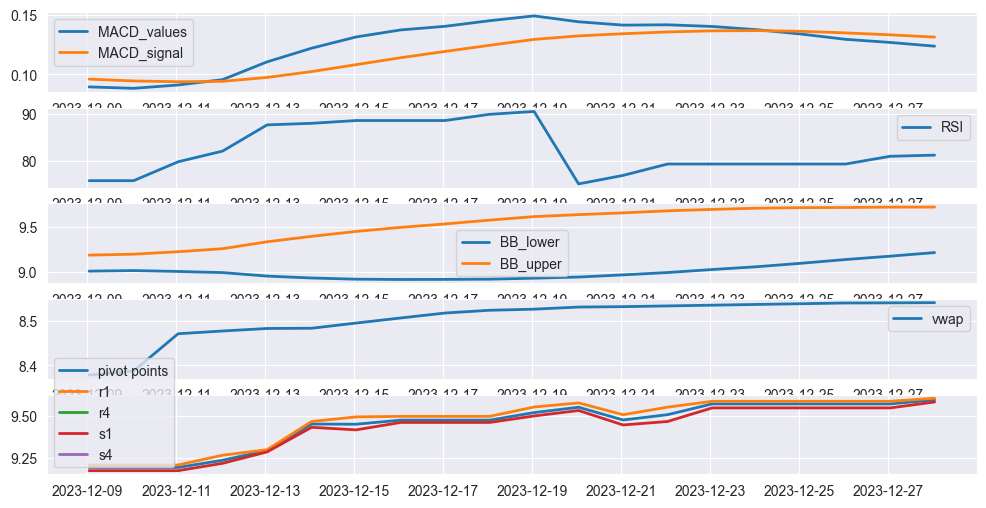

In [399]:
fund_name_fund_df, sum_plt = technical_indicators_factory(dataframes_funds, funds_for_hedge)

In [400]:
transformers=[]
vals=[]

In [ ]:
for fund in fund_name_fund_df:
    tft, val = fit(epochs=10, batch_size=128, df=fund_name_fund_df[fund], independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"])
    transformers.append(tft)
    vals.append(val)

In [404]:
pred = []
for i in range(len(fund_name_fund_df)):
    pred.append(predictt(transformers[i], vals[i]))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


361
31


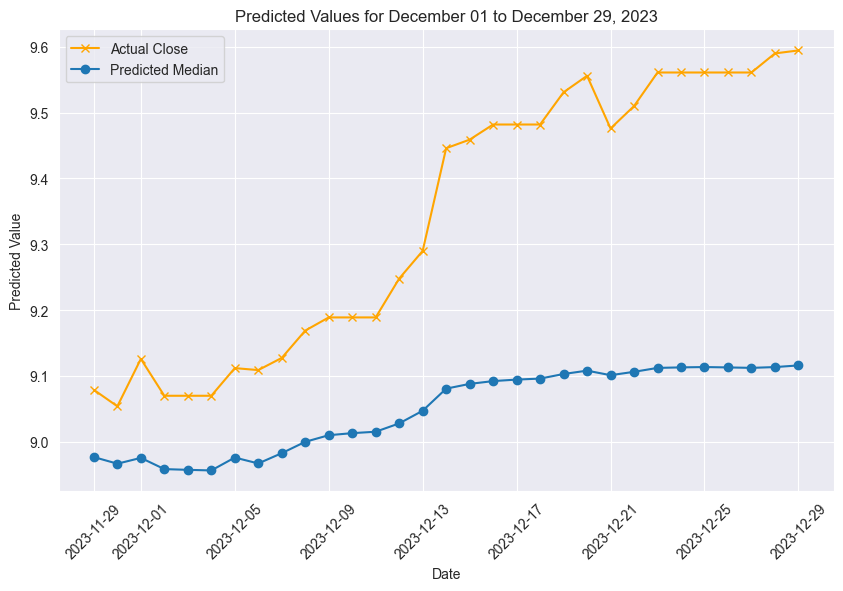

In [405]:
IE_many1_rse, IE_many1_rae, IE_many1_hub, IE_many1_plt2,= metrics_and_plt(funds_w_names[funds_for_hedge[0]], pred[0][-31:], pd.date_range(start="2023-11-29", end="2023-12-29"), date="2023-11-28")

In [ ]:
# GIGAFUND_NORM = GIGAFUND.copy()
# 
# columns_to_normalize = ["Open", "High", "Low", "Close", "Volume", "Return", "Rolling Volatility"]
# 
# GIGAFUND_NORM[columns_to_normalize] = (
#     GIGAFUND_NORM[columns_to_normalize]
#     .apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0)
# )

In [ ]:
# duplicate_rows = GIGAFUND_NORM[GIGAFUND_NORM.duplicated(subset=["time_idx", "group_id"], keep=False)]
# print(duplicate_rows)

In [ ]:
# gftft, gftr, gfv = fit(epochs=10, batch_size=128, lr=1e-3, dropout=0.1, df=GIGAFUND_NORM, independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"], target="Close")

In [ ]:
# IE_indicators_preds = predictt(gftft, gftr, gfv)

In [ ]:
# normalized = dataframes_funds[1][columns_to_normalize] = (
#     dataframes_funds[1][columns_to_normalize]
#     .apply(lambda col: (col - col.min()) / (col.max() - col.min()), axis=0)
# )

In [ ]:
# mse, plt, mape, huber = metrics_and_plt(dataframes_funds[1], IE_indicators_preds, pd.date_range(start="2023-10-29", end="2023-12-29"), date="2023-10-29")

5) MANY FUNDS, INDICATORS, RESIDUALS

In [414]:
resztkiii = []
for i in range(len(funds_for_hedge)):
    resztkiii.append(abs(pred[i] - fund_name_fund_df[funds_for_hedge[i]]["Close"]["2023-10-29":"2023-12-29"]))

In [415]:
residualsss=[]
for i in range(len(funds_for_hedge)):
    residualsss.append(fund_name_fund_df[funds_for_hedge[i]][300:].copy())
    residualsss[i]["Remainders"] = resztkiii[i]
    residualsss[i].index = pd.to_datetime(residualsss[i].index)  # ensure index is datetime if not already
    residualsss[i]["time_idx"] = (residualsss[i].index.date - residualsss[i].index.date[0]).astype("timedelta64[D]").astype(int)
    residualsss[i]['group_id'] = fund_name_fund_df[funds_for_hedge[i]][300:]["group_id"]

In [416]:
transformers_res=[]
vals_res=[]
for i in range(len(funds_for_hedge)):
    tft, val = fit(epochs=100, batch_size=128, df=residualsss[i], independent_variables=["Open", "High", "Low", "isOverbought", "Bullish"], target="Remainders", max_prediction_length=31)
    transformers_res.append(tft)
    vals_res.append(val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 880    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 38.1 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 89.8 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 76.7 K | train
7  | static_context_variable_selection  | GatedResidualNetwork 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [418]:
res_preds = []
for i in range(len(funds_for_hedge)):
    res_preds.append(predictt(transformers_res[i], vals_res[i]))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


31
31


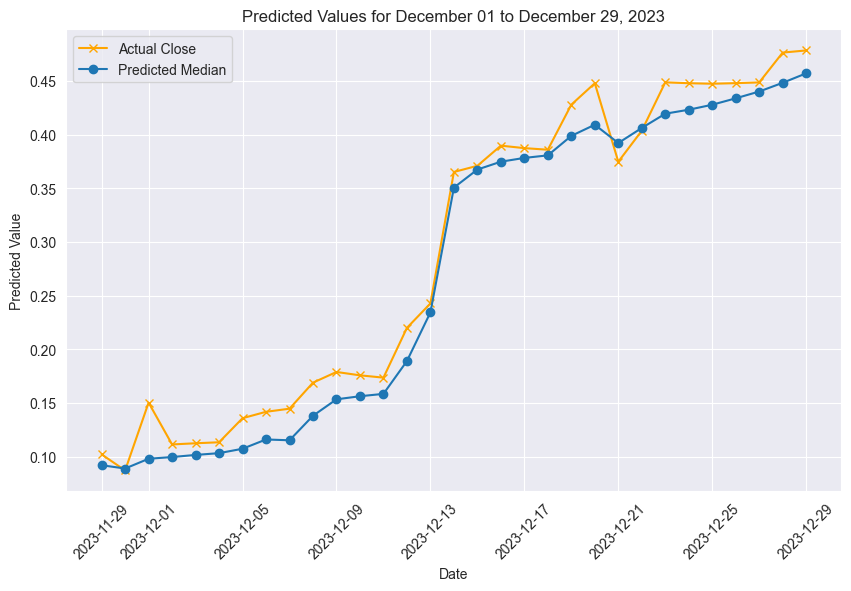

In [419]:
IE_many1_res_rse, IE_many1_res_rae, IE_many1_res_huber, IE_many1_res_plt = metrics_and_plt(residualsss[0][30:], res_preds[0],pd.date_range(start="2023-11-29", end="2023-12-29"), target="Remainders", date="2023-11-28")

In [ ]:
print(IE_many1_res_rse, IE_many1_res_rae, IE_many1_res_huber)

6) FINAL RESULT PRICE + RESIDUALS

In [420]:
final_many_preds = []
for i in range(len(funds_for_hedge)):
    final_many_preds.append(pred[i].copy()[-31:] + res_preds[i])

331
31


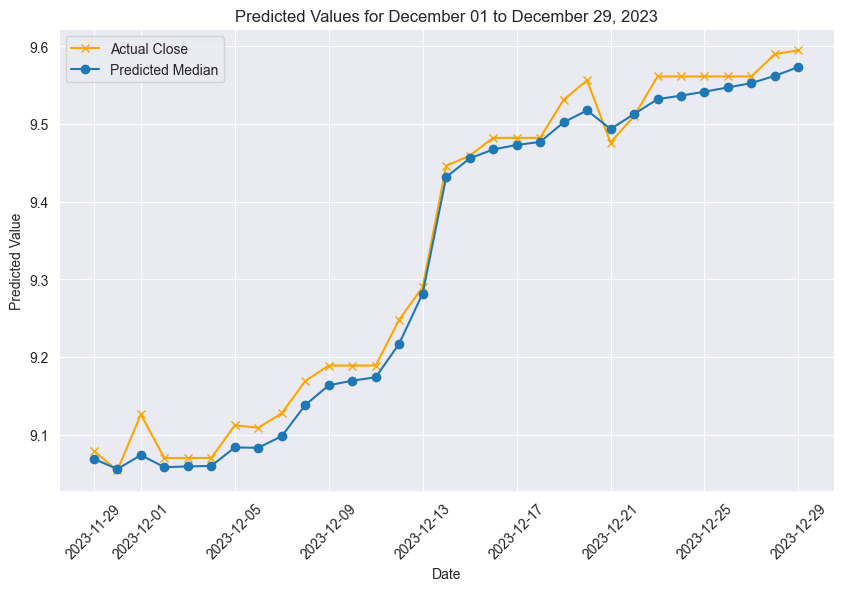

In [421]:
IE_final_many1_res_rse, IE_final_many1_res_rae, IE_final_many1_res_huber, IE_final_many1_res_plt = metrics_and_plt(funds_w_names[funds_for_hedge[0]][30:], final_many_preds[0],pd.date_range(start="2023-11-29", end="2023-12-29"), target="Close", date="2023-11-28")

MONTER CARLOS PREDICTING RISK

In [ ]:
def calc_drift(fund):
    log_returns = np.log(1+fund["Close"].pct_change())
    log_returns.fillna(value=0, inplace=True)
    avg_pdr = log_returns.mean()
    var = log_returns.var()
    drift = avg_pdr-(.5*var)

    return drift

In [ ]:
def monte_carlo_sim(fund):
    drift = calc_drift(fund)
    log_returns = np.log(1+fund["Close"].pct_change())
    log_returns.fillna(value=0, inplace=True)
    stdev=log_returns.std()
    days=362
    trials=100
    Z = norm.ppf(np.random.rand(days,trials))
    daily_returns=np.exp(np.array(drift) + np.array(stdev) * Z)
    price_paths = np.zeros_like(daily_returns)
    price_paths[0] = fund["Close"].iloc[-1]
    for i in range(1,days):
        price_paths[i] = price_paths[i-1] * daily_returns[i]
    return price_paths

In [ ]:
drifts=calc_drift(funds_w_names["EWSA.AS"])
pp=monte_carlo_sim(funds_w_names["EWSA.AS"])

In [ ]:
def volatility_mc(price_paths: pd.DataFrame):
    pp_df = pd.DataFrame(price_paths)
    pp_df= pp_df.pct_change()
    pp_df.fillna(value=0, inplace=True)
    pp_df=pp_df.rolling(7).std()
    pp_df.fillna(method="bfill", inplace=True)
    return np.mean(pp_df)

In [ ]:
volatility_mc(pp)

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(pp)

TEZ DO KOSZA

In [ ]:
list_of_5_df_funds = []

In [ ]:
def nearest_positive_definite(matrix):
    P = matrix.copy()
    eigvals, eigvecs = np.linalg.eigh(P)
    eigvals[eigvals < 0] = 1e-10
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

In [ ]:
variances = {}
covs_means = []
for k,v in funds_w_names.items():
    variances[k] = v["Rolling Volatility"]
variances = pd.DataFrame(variances)
r = variances.pct_change()
covariance_matrix = r.cov()
mean_returns = r.mean()

In [ ]:
if not np.all(np.linalg.eigvals(covariance_matrix) > 0):
    print("Covariance matrix not positive definite. Adding regularization.")
    covariance_matrix = nearest_positive_definite(covariance_matrix)

In [ ]:
#to be filled with real data
portfolio_weights = np.random.random(len(mean_returns)) # distribution of etfs in portfolio
portfolio_weights /= np.sum(portfolio_weights)

In [ ]:
initial_portfoloio = 0
for i, v in enumerate(funds_w_names.values()):
    initial_portfoloio += portfolio_weights[i] * v["Close"][i]

In [ ]:
days = 60
simulations = 100
portfolio_sims = np.full(shape=(days, simulations), fill_value=0.0) # default
mean_matrix = np.full(shape=(days, len(portfolio_weights)), fill_value=mean_returns).T # days x all etfs

In [ ]:
initial_portfoloio

In [ ]:
for s in range(0, simulations):
    Z = np.random.normal(size=(days, len(portfolio_weights)))
    L = np.linalg.cholesky(covariance_matrix)
    daily_returns = mean_matrix + np.inner(L, Z)
    portfolio_sims[:, s] = np.cumprod(np.inner(portfolio_weights, daily_returns.T)+1)*initial_portfoloio

plt.plot(portfolio_sims)
plt.ylabel("Portfolio Simulations")

expected volatility

In [ ]:
portfolio_returns = portfolio_sims[-1] / portfolio_sims[0] - 1  # final value over initial value gives portfolio returns
portfolio_volatility = np.std(portfolio_returns)
print(f"Portfolio Volatility: {portfolio_volatility:.4f}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_sims)
plt.title("Monte Carlo Simulations of Portfolio Value")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.show()

expected return

In [ ]:
discounted_prices = [sim[-1]*0.96 for sim in portfolio_sims]

In [ ]:
avg = np.average(discounted_prices)

MONTE CARLO EVALUATION FUNCITON

In [ ]:
def test_robustness(paths, num_trials, tol=0.01):
    means = []
    for i in range(num_trials):
        np.random.seed(i)
        new_paths = np.random.choice(paths, size=len(paths), replace=True)
        means.append(np.mean(new_paths))
    glob_mean = np.mean(means)
    devs = np.abs(np.array(means) - glob_mean)
    return max(0, 1 - (np.mean(devs) / (tol*glob_mean)))

In [ ]:
def compute_convergence_rate(paths, true_val):
    cum_means = np.cumsum(paths)/np.arange(1, len(paths)+1)
    difs = np.abs(cum_means - true_val)
    final = difs[-1]
    avg = np.mean(difs)
    if avg == 0.0:
        return 1.0
    return max(0, 1-(final/avg))

In [ ]:
def rate_mc_simulation(paths, true_value, runtime, weights):
    mean_estimate = np.mean(paths)
    variance = np.var(paths)
    bias = mean_estimate - np.mean(true_value)
    mse = bias**2 + variance
    efficiency = 1 / (runtime * mse)

    robustness = test_robustness(paths.mean(axis=1), 150)

    convergence_rate = compute_convergence_rate(paths.mean(axis=1), true_value)

    score = (
            weights[0] * convergence_rate +
            weights[1] * (1 / np.std(paths)) +
            weights[2] * (1 / abs(bias)) +
            weights[3] * (1 / variance) +
            weights[4] * efficiency +
            weights[5] * robustness)
    return score

In [ ]:
weights=[1/6,1/6,1/6,1/6,1/6,1/6]
pd.Series(pp['EWSA.AS'].mean(axis=1))

In [ ]:
print((rate_mc_simulation(pp['EWSA.AS'], funds_w_names["EWSA.AS"]["Close"], 0.1, weights)))

REDESIGN PORTFOLIO

In [ ]:
'''
list of predictions for each fund in portfolio
'''
portfolio = funds_for_hedge
preds_for_portfolio = []
for i in portfolio:
    preds_for_portfolio.append(predictt(29, funds_w_names[i]))

In [ ]:
'''
calculate ratio of a single fund based on provided predictions
'''
def calculate_funds_ratio(funds_preds, fund: pd.DataFrame):
    funds_return = fund["Close"].iloc[-1] - funds_preds["Close"].iloc[-1]
    funds_risk = volatility_mc(monte_carlo_sim(fund))
    data = yf.Ticker("^TNX").history(period="1d")
    risk_free_rate = data['Close'].iloc[-1] / 100
    sharpe_ratio = (funds_return / len(fund)) - risk_free_rate / funds_risk
    return sharpe_ratio, funds_return #funds_return/funds_risk

In [ ]:
def redistribute_funds(funds_dfs:list, weights: list):
    """
    for a given portfolio, calculate risk and return for next month for each asset and decide whether to buy more of it
    funds_dfs is a list of funds dataframes based on portfolio
    weights is a list of weights for each funds
    """

    def objective(w):
        portfolio_score = 0
        for i in (range(len(funds_dfs))):
            ratio, returnn, preds = calculate_funds_ratio(preds_for_portfolio, funds_dfs[i])
            portfolio_score += ratio * w[i]
            return -portfolio_score

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0,1)] * len(funds_dfs)
    result = minimize(objective, np.ndarray(weights), method='SLSQP', bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    optimized_score = result.fun

    returns = [calculate_funds_ratio(preds_for_portfolio[i], funds_dfs[i])[1] for i in range(len(portfolio))]
    final_gain = optimized_weights*returns

    return optimized_weights, optimized_score, final_gain

works for small Ns, max 10

In [ ]:
import numpy as np
import pandas as pd

def design_optimal_portfolio(N: int):
    available_funds = list(funds_w_names.keys())
    fund_combinations = list(combinations(available_funds, N))

    best_score = -np.inf
    best_weights = None
    best_selected_funds = None
    best_final_gains = None

    for selected_funds in fund_combinations:

        funds_dfs = [funds_w_names[fund] for fund in selected_funds]


        preds_for_selected_funds = []
        for fund in selected_funds:
            preds_for_selected_funds.append(predictt(29, funds_w_names[fund]))


        def objective(w):
            portfolio_score = 0
            for i in range(len(funds_dfs)):
                ratio, returnn, _ = calculate_funds_ratio(preds_for_selected_funds[i], funds_dfs[i])
                portfolio_score += ratio * w[i]
            return -portfolio_score


        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        bounds = [(0, 1)] * N

        initial_weights = np.ones(N) / N

        result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

        optimized_weights = result.x
        optimized_score = -result.fun

        returns = [calculate_funds_ratio(preds_for_selected_funds[i], funds_dfs[i])[1] for i in range(N)]
        final_gains = np.dot(optimized_weights, returns)

        if optimized_score > best_score:
            best_score = optimized_score
            best_weights = optimized_weights
            best_selected_funds = selected_funds
            best_final_gains = final_gains

    return best_weights, best_score, best_final_gains, best_selected_funds

In [ ]:
N = 5
best_weights, best_score, best_final_gains, best_selected_funds = design_optimal_portfolio(N)

print("Selected funds:", best_selected_funds)
print("Optimized weights:", best_weights)
print("Best gain:", best_final_gains)

works for large Ns

In [ ]:
import random
from scipy.optimize import minimize
from itertools import combinations

def calculate_fitness(preds_for_selected_funds, funds_dfs, weights):
    portfolio_score = 0
    for i in range(len(funds_dfs)):
        ratio, returnn, _ = calculate_funds_ratio(preds_for_selected_funds[i], funds_dfs[i])
        portfolio_score += ratio * weights[i]
    return portfolio_score

def genetic_algorithm(funds_w_names, N, population_size=50, generations=100, mutation_rate=0.1, crossover_rate=0.8):
    available_funds = list(funds_w_names.keys())
    fund_combinations = list(combinations(available_funds, N))

    population = []
    for _ in range(population_size):
        selected_funds = random.sample(fund_combinations, 1)[0]
        weights = np.random.rand(N)
        weights /= np.sum(weights)
        population.append((selected_funds, weights))

    best_solution = None
    best_fitness = -np.inf

    for generation in range(generations):
        fitness_scores = []
        preds_for_selected_funds_list = []
        funds_dfs_list = []

        for selected_funds, _ in population:
            funds_dfs = [funds_w_names[fund] for fund in selected_funds]
            preds_for_selected_funds = []
            for fund in selected_funds:
                preds_for_selected_funds.append(predictt(29, funds_w_names[fund]))
            preds_for_selected_funds_list.append(preds_for_selected_funds)
            funds_dfs_list.append(funds_dfs)

        for i in range(population_size):
            selected_funds, weights = population[i]
            fitness = calculate_fitness(preds_for_selected_funds_list[i], funds_dfs_list[i], weights)
            fitness_scores.append(fitness)
            if fitness > best_fitness:
                best_fitness = fitness
                best_solution = (selected_funds, weights)

        selected_parents = []
        fitness_sum = np.sum(fitness_scores)
        prob = [score / fitness_sum for score in fitness_scores]

        for _ in range(population_size):
            selected_parent = random.choices(population, prob)[0]
            selected_parents.append(selected_parent)

        new_population = []
        for i in range(0, population_size, 2):
            parent1, parent2 = selected_parents[i], selected_parents[i+1]
            if random.random() < crossover_rate:
                crossover_point = random.randint(1, N-1)  # Crossover at a random point
                offspring1 = (parent1[0][:crossover_point] + parent2[0][crossover_point:],
                              np.concatenate((parent1[1][:crossover_point], parent2[1][crossover_point:])))
                offspring2 = (parent2[0][:crossover_point] + parent1[0][crossover_point:],
                              np.concatenate((parent2[1][:crossover_point], parent1[1][crossover_point:])))
                new_population.extend([offspring1, offspring2])
            else:
                new_population.extend([parent1, parent2])

        for i in range(population_size):
            if random.random() < mutation_rate:
                selected_funds, weights = new_population[i]
                mutation_idx = random.randint(0, N-1)
                weights[mutation_idx] = random.random()
                weights /= np.sum(weights)  # Normalize weights to sum to 1
                new_population[i] = (selected_funds, weights)

        population = new_population

    return best_solution, best_fitness

In [ ]:
N = 5
best_solution, best_fitness = genetic_algorithm(funds_w_names, N)

selected_funds, optimized_weights = best_solution
print("Selected funds:", selected_funds)
print("Optimized weights:", optimized_weights)
print("Best fitness (risk-adjusted return):", best_fitness)